In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Activation

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [3]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 17816229998775575941]

In [4]:
df = pd.read_csv('data/medibloc.csv', encoding='cp949')
df.head()

,날짜,시가,고가,저가,종가,거래량,시가총액
0,04-Apr-20,2.93,2.96,2.86,2.91,"156,557,373","7,257,735,356"
1,05-Apr-20,2.92,2.94,2.85,2.88,"111,694,036","7,171,533,960"
2,06-Apr-20,2.88,3.05,2.85,3.05,"305,791,568","7,614,393,498"
3,07-Apr-20,3.05,3.08,2.94,2.97,"293,938,261","7,418,205,862"
4,08-Apr-20,2.97,3.07,2.95,3.02,"157,477,523","7,535,574,853"


In [5]:
# 당일 중간가격 구하기
high_prices = df['고가'].values
low_prices = df['저가'].values
mid_prices = (high_prices+low_prices)/2 

In [6]:
len(mid_prices)

364

In [7]:
# 최근 7일을 기준으로 다음날 가격을 예측
seq_len = 7
squence_length = seq_len + 1
result = []
for index in range(len(mid_prices) - squence_length):
    result.append(mid_prices[index: index + squence_length])

In [8]:
result[0]

array([2.91 , 2.895, 2.95 , 3.01 , 3.01 , 3.035, 2.92 , 2.835])

In [9]:
# 정규화
normalized_data = []
for window in result:
    normalized_window = [((float(p)/float(window[0])) - 1)for p in window]
    normalized_data.append(normalized_window)
    
result = np.array(normalized_data)

In [10]:
result.shape

(356, 8)

In [11]:
#data split
row = int(round(result.shape[0]*0.9))
train = result[:row,:]
np.random.shuffle(train)

x_train = train[:,:-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))
y_train = train[:,-1]

x_test = result[row:,:-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))
y_test = result[row:,-1]
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((320, 7, 1), (36, 7, 1), (320,), (36,))

In [12]:
# LSTM  모델구현
model = Sequential()
model.add(LSTM(50,return_sequences=True, input_shape=(7,1)))
model.add(LSTM(64,return_sequences=False))
model.add(Dense(1,activation='relu'))
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 50)             10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 39,905
Trainable params: 39,905
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.fit(x_train, y_train,
          validation_data=(x_test, y_test),
          batch_size=10, epochs=200)

Epoch 1/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0144 - val_loss: 0.0668
Epoch 2/200
32/32 [==============================] - 0s 4ms/step - loss: 0.0145 - val_loss: 0.0566
Epoch 3/200
32/32 [==============================] - 0s 4ms/step - loss: 0.0141 - val_loss: 0.0630
Epoch 4/200
32/32 [==============================] - 0s 4ms/step - loss: 0.0139 - val_loss: 0.0596
Epoch 5/200
32/32 [==============================] - 0s 4ms/step - loss: 0.0140 - val_loss: 0.0603
Epoch 6/200
32/32 [==============================] - 0s 4ms/step - loss: 0.0140 - val_loss: 0.0626
Epoch 7/200
32/32 [==============================] - 0s 4ms/step - loss: 0.0140 - val_loss: 0.0558
Epoch 8/200
32/32 [==============================] - 0s 4ms/step - loss: 0.0140 - val_loss: 0.0750
Epoch 9/200
32/32 [==============================] - 0s 4ms/step - loss: 0.0140 - val_loss: 0.0585
Epoch 10/200
32/32 [==============================] - 0s 4ms/step - loss: 0.0138 - val_loss: 0.0631
Epoch 11/

32/32 [==============================] - 0s 4ms/step - loss: 0.0064 - val_loss: 0.1250
Epoch 84/200
32/32 [==============================] - 0s 4ms/step - loss: 0.0063 - val_loss: 0.1552
Epoch 85/200
32/32 [==============================] - 0s 4ms/step - loss: 0.0068 - val_loss: 0.1268
Epoch 86/200
32/32 [==============================] - 0s 4ms/step - loss: 0.0063 - val_loss: 0.1243
Epoch 87/200
32/32 [==============================] - 0s 4ms/step - loss: 0.0063 - val_loss: 0.1321
Epoch 88/200
32/32 [==============================] - 0s 4ms/step - loss: 0.0061 - val_loss: 0.1371
Epoch 89/200
32/32 [==============================] - 0s 4ms/step - loss: 0.0062 - val_loss: 0.1260
Epoch 90/200
32/32 [==============================] - 0s 4ms/step - loss: 0.0061 - val_loss: 0.1267
Epoch 91/200
32/32 [==============================] - 0s 4ms/step - loss: 0.0059 - val_loss: 0.1431
Epoch 92/200
32/32 [==============================] - 0s 4ms/step - loss: 0.0066 - val_loss: 0.1292
Epoch 93/200


32/32 [==============================] - 0s 4ms/step - loss: 0.0059 - val_loss: 0.1102
Epoch 165/200
32/32 [==============================] - 0s 4ms/step - loss: 0.0058 - val_loss: 0.1060
Epoch 166/200
32/32 [==============================] - 0s 4ms/step - loss: 0.0059 - val_loss: 0.1214
Epoch 167/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0058 - val_loss: 0.1113
Epoch 168/200
32/32 [==============================] - 0s 4ms/step - loss: 0.0059 - val_loss: 0.1032
Epoch 169/200
32/32 [==============================] - 0s 4ms/step - loss: 0.0062 - val_loss: 0.1062
Epoch 170/200
32/32 [==============================] - 0s 4ms/step - loss: 0.0058 - val_loss: 0.1118
Epoch 171/200
32/32 [==============================] - 0s 4ms/step - loss: 0.0058 - val_loss: 0.1161
Epoch 172/200
32/32 [==============================] - 0s 4ms/step - loss: 0.0058 - val_loss: 0.1067
Epoch 173/200
32/32 [==============================] - 0s 4ms/step - loss: 0.0058 - val_loss: 0.1105
Epoc

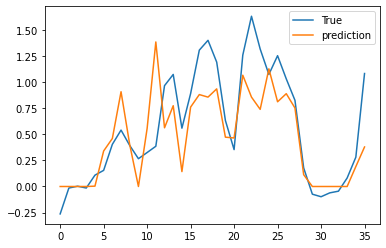

In [18]:
pred = model.predict(x_test)

fig = plt.figure(facecolor='white')
ax = fig.add_subplot(1,1,1)
ax.plot(y_test,label='True')
ax.plot(pred, label='prediction')
ax.legend()
plt.show()